<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [194]:
import gdown
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
import seaborn as sns

from keras.layers.core import Dropout, Dense
from keras.layers import Embedding, Input, LSTM, Bidirectional, Concatenate
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences # se utilizará para padding
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from pathlib import Path

In [159]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [160]:
# dataset_file
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [161]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [162]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [163]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [67]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [164]:
# Tokenizar las palabras con el Tokenizer de Keras
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [165]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(['<sos>', '<eos>'] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer 
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


In [166]:
# A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. 
# Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), 
# mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [167]:
# La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
# Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [13]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [14]:
model_embeddings = FasttextEmbeddings()

In [168]:
# Crear la Embedding matrix de las secuencias
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', len(words_not_found))

preparing embedding matrix...
number of null word embeddings: 0


In [169]:
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [74]:
n_units = 128

In [182]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dropout
dropout = Dropout(rate=0.3)
decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 9, 300)       539700      input_67[0][0]                   
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 10, 128)      231296      input_68[0][0]                   
___________________________________________________________________________________________

In [183]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 8s 25ms/step - loss: 3.1121 - accuracy: 0.5083 - val_loss: 2.3108 - val_accuracy: 0.6036
Epoch 2/50
151/151 [==============================] - 3s 21ms/step - loss: 2.1406 - accuracy: 0.6138 - val_loss: 2.1352 - val_accuracy: 0.6470
Epoch 3/50
151/151 [==============================] - 3s 20ms/step - loss: 1.9193 - accuracy: 0.6636 - val_loss: 1.9845 - val_accuracy: 0.6727
Epoch 4/50
151/151 [==============================] - 3s 20ms/step - loss: 1.7383 - accuracy: 0.6982 - val_loss: 1.8782 - val_accuracy: 0.6964
Epoch 5/50
151/151 [==============================] - 3s 20ms/step - loss: 1.6207 - accuracy: 0.7159 - val_loss: 1.8166 - val_accuracy: 0.7024
Epoch 6/50
151/151 [==============================] - 3s 20ms/step - loss: 1.5405 - accuracy: 0.7234 - val_loss: 1.7761 - val_accuracy: 0.7073
Epoch 7/50
151/151 [==============================] - 3s 20ms/step - loss: 1.4859 - accuracy: 0.7269 - val_loss: 1.7466 - val_accuracy: 0.7080

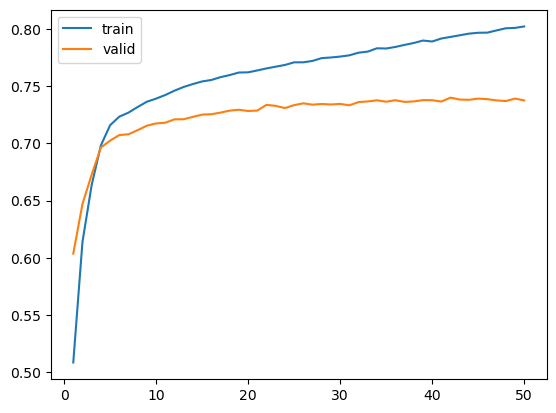

In [184]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

##### Modelo con Stack de LSTM (2 capas)

In [185]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_outputs, _, _ = encoder_lstm1(encoder_inputs_x)
encoder_lstm2 = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, h1, c1 = decoder_lstm1(decoder_inputs_x, initial_state=encoder_states)
decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs, initial_state=encoder_states)

# Dropout
dropout = Dropout(rate=0.3)
decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 9, 300)       539700      input_69[0][0]                   
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
lstm_68 (LSTM)                  [(None, 9, 128), (No 219648      embedding_44[0][0]               
___________________________________________________________________________________________

In [186]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=60, 
    validation_split=0.2)

Epoch 1/60
151/151 [==============================] - 12s 36ms/step - loss: 3.0934 - accuracy: 0.5085 - val_loss: 2.5561 - val_accuracy: 0.5507
Epoch 2/60
151/151 [==============================] - 4s 27ms/step - loss: 2.2747 - accuracy: 0.5737 - val_loss: 2.1588 - val_accuracy: 0.6321
Epoch 3/60
151/151 [==============================] - 4s 27ms/step - loss: 1.9885 - accuracy: 0.6286 - val_loss: 2.0790 - val_accuracy: 0.6476
Epoch 4/60
151/151 [==============================] - 4s 27ms/step - loss: 1.8499 - accuracy: 0.6623 - val_loss: 1.9662 - val_accuracy: 0.6780
Epoch 5/60
151/151 [==============================] - 4s 27ms/step - loss: 1.7157 - accuracy: 0.6947 - val_loss: 1.8944 - val_accuracy: 0.6900
Epoch 6/60
151/151 [==============================] - 4s 27ms/step - loss: 1.6192 - accuracy: 0.7102 - val_loss: 1.8422 - val_accuracy: 0.6950
Epoch 7/60
151/151 [==============================] - 4s 27ms/step - loss: 1.5543 - accuracy: 0.7180 - val_loss: 1.8082 - val_accuracy: 0.699

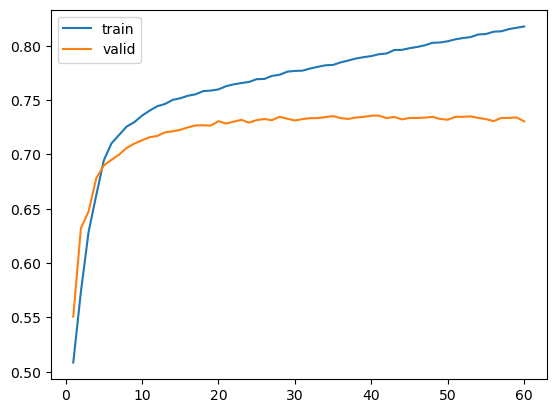

In [187]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

##### Modelo con Stack de LSTM (3 capas)

In [188]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_outputs, _, _ = encoder_lstm1(encoder_inputs_x)
encoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_outputs, _, _ = encoder_lstm2(encoder_inputs_x)
encoder_lstm3 = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs)

encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, h1, c1 = decoder_lstm1(decoder_inputs_x, initial_state=encoder_states)
decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, h2, c2 = decoder_lstm2(decoder_outputs, initial_state=encoder_states)
decoder_lstm3 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm3(decoder_outputs, initial_state=encoder_states)

# Dropout
dropout = Dropout(rate=0.2)
decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 9, 300)       539700      input_71[0][0]                   
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
lstm_73 (LSTM)                  [(None, 9, 128), (No 219648      embedding_46[0][0]               
___________________________________________________________________________________________

In [189]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=60, 
    validation_split=0.2)

Epoch 1/60
151/151 [==============================] - 15s 48ms/step - loss: 3.0729 - accuracy: 0.5091 - val_loss: 2.5724 - val_accuracy: 0.5506
Epoch 2/60
151/151 [==============================] - 5s 30ms/step - loss: 2.4629 - accuracy: 0.5273 - val_loss: 2.5252 - val_accuracy: 0.5458
Epoch 3/60
151/151 [==============================] - 5s 32ms/step - loss: 2.4073 - accuracy: 0.5319 - val_loss: 2.5085 - val_accuracy: 0.5473
Epoch 4/60
151/151 [==============================] - 6s 39ms/step - loss: 2.1981 - accuracy: 0.5759 - val_loss: 2.1371 - val_accuracy: 0.6331
Epoch 5/60
151/151 [==============================] - 8s 51ms/step - loss: 1.9026 - accuracy: 0.6447 - val_loss: 2.0290 - val_accuracy: 0.6599
Epoch 6/60
151/151 [==============================] - 8s 54ms/step - loss: 1.7676 - accuracy: 0.6853 - val_loss: 1.9631 - val_accuracy: 0.6786
Epoch 7/60
151/151 [==============================] - 5s 33ms/step - loss: 1.6725 - accuracy: 0.7071 - val_loss: 1.9219 - val_accuracy: 0.683

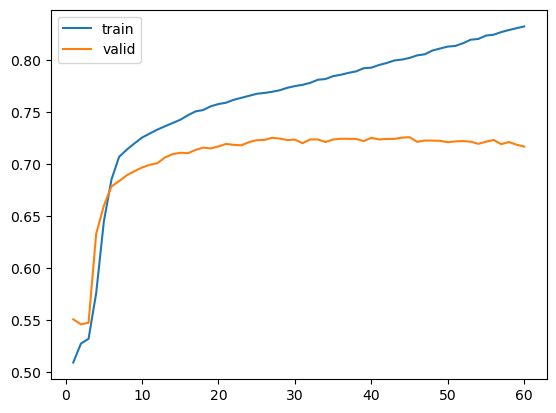

In [190]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

Re-entreno el mejor modelo segun los resultados anteriores

In [195]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = Bidirectional(LSTM(n_units, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs_x)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dropout
dropout = Dropout(rate=0.3)
decoder_outputs = dropout(decoder_outputs)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 9, 300)       539700      input_73[0][0]                   
__________________________________________________________________________________________________
input_74 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 439296      embedding_48[0][0]               
___________________________________________________________________________________________

In [196]:
# Define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

In [197]:
# Define inference decoder
decoder_state_input_h = Input(shape=(n_units*2,))
decoder_state_input_c = Input(shape=(n_units*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [198]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=60, 
    validation_split=0.2)

Epoch 1/60
151/151 [==============================] - 12s 46ms/step - loss: 2.7228 - accuracy: 0.5537 - val_loss: 2.1519 - val_accuracy: 0.6336
Epoch 2/60
151/151 [==============================] - 3s 22ms/step - loss: 1.8935 - accuracy: 0.6639 - val_loss: 1.9165 - val_accuracy: 0.6911
Epoch 3/60
151/151 [==============================] - 5s 36ms/step - loss: 1.6332 - accuracy: 0.7128 - val_loss: 1.8006 - val_accuracy: 0.6997
Epoch 4/60
151/151 [==============================] - 6s 37ms/step - loss: 1.4963 - accuracy: 0.7286 - val_loss: 1.7374 - val_accuracy: 0.7141
Epoch 5/60
151/151 [==============================] - 5s 36ms/step - loss: 1.4064 - accuracy: 0.7410 - val_loss: 1.6983 - val_accuracy: 0.7174
Epoch 6/60
151/151 [==============================] - 4s 28ms/step - loss: 1.3403 - accuracy: 0.7462 - val_loss: 1.6680 - val_accuracy: 0.7204
Epoch 7/60
151/151 [==============================] - 2s 15ms/step - loss: 1.2847 - accuracy: 0.7522 - val_loss: 1.6435 - val_accuracy: 0.725

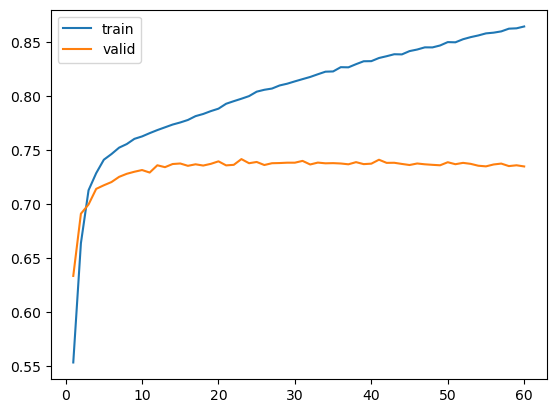

In [199]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [200]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [201]:
def answer_question(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como ""
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece " se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [202]:
input_test = 'Do you read?'
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
Response: i do not know what to say


In [203]:
input_test = 'Where are you from?'
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
Response: i am from the united states


In [204]:
input_test = 'Do you have any pet?'
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
Response: no


### 6 - Conclusiones

- Se implementaron 4 modelos con la arquitectura Encoder-Decoder. 
  - Una sola capa LSTM
  - 2 capas LSTM
  - 3 capas LSTM
  - Una sola capa con LSTM Bidireccional
  
Agregar dropout mejoró un poco el overfitting. El modelo con una sola capa fue el mejor, practicamente no se vieron diferencias entre tener un encoder LSTM común o uno bidireccional.

A nivel respuesta, se observan muy buenos resultados respecto a la coherencia y a la estructura gramatical de las respuestas.